In [1]:
#######
#######  VERSION 8
#######  ADDED IN THE ABILITY TO SIMULATE THE DUAL FITTING BEFORE FITTING, SO THAT WE CAN CHECK INITIAL GUESSES. 
#######
#######  A LIST OF THINGS THAT CAN BE FIXXED AND IMPROVED...
#######     1. We can figure out how to calculate the error on the eta and FWHM terms from the fit
#######     2. We can make it so that our fit and exp b-fild are not different. 
#######           - to do this, basically, add in a new value for the fit-x to either end.  Can just use the spacing between two points to dtermine the values. 
#######           - since these are only used to simulate, using them to calculate the simulated data is fine
#######           - and then we will lose these points when we simulate anyway. 
#######           - when we do this, need to make sure that the data we are comparing to in the fit is the same length... right now it is truncated, because we lose two points... 
#######
#######

# This is a re-build of the Psuedovoight powder EPR fitter, now that I have a better idea of how it works...

######################
#  CONSTANTS
#######################

h = 6.626*10**-34       # Planck's constant (in J * s)
#pi = 3.14159          # this is pi  #but instead of defining by separatelyl, in python we will just use np.pi
gr = (1 + 5**0.5)/2  #golden ratio
beta  = 9.2740 * 10**-24    # Bohr Magneton (in J / T)



######################
# SAMPLING OF SPHERE
######################
#we are going to make a function that we can call to generate a sampling of points in a sphere. We really only have to do this once.  
#I could even make a file with them, and then always use that.  But we can dynamically adjust the resolution as we like
# the input is really just the resolution
# the return is going to be a pair of vectors, or lists.  Then we can convert these to a data frame outside the function? 
# or should we return the data frame???

#Then we might as well generate this here, so that we don't have to do it over and over again.  ONLY NEED THIS ONCE. 
#FIRST, we decide how many points we want.  
mesh = 500  # this is the number of total angle pairs calculated for each magnetic field.  If this number is too low, you get osscilations
mesh = mesh*8  # we multiply by 8, since we will reduce this to a single quadrant of the sphere. 

def sphere_sampling(mesh_sphere) :
    import numpy as np
    gr = (1 + 5**0.5)/2  #golden ratio
    
    #this is one approach, that uses the appraoch from LATTICE 3 in Extreme learning: 
    #http://extremelearning.com.au/evenly-distributing-points-on-a-sphere/
    
    #we are going to generate a paired list of points. That is, two lists, where common idexes represent a pair of values. 

    #start with the i = 0 points.  This will be theta = 0, phi = 0...
    # we are starting with x and y, because the appraoch first generates the uniform sampling of a rectangle, and then converts this to a sphere. 
    # so we start in cartesian space...
    
    #for speed, we are going to work with a list first, and then convert this to an array once we have the full length...
    x = [0]
    y = [0]

    #then move on to i = 1 through i = mesh_sphere-1
    #i is both an index and the way we calculate the values
    i = 1

    while i < mesh_sphere :
        x.append((i + 6) / (mesh_sphere + 11))
        y.append(i / gr)
        i += 1

    #finally, the value for i = mesh_sphere

    x.append(1)
    y.append(0)
    
    #then we convert to an array to make math easy... 
    x = np.array(x)
    y = np.array(y)
    
    y = y % 1  #we want to convert to the unit square, and we do this by using the modulo operator
    
    # then we want to convert the unit square to equally spaced polar coordinates. 
    thetas = np.arccos(2*x-1)
    phis = 2*np.pi*y
    
    #convert the array back to list, so that sorting through it is easier...
    thetas = np.array(thetas).tolist()
    phis = np.array(phis).tolist()

    #print(thetas)

    #########
    # REDUCE THE SAMPLING TO A QUADRANT
    ########
    # the above gives a uniform sampling of a sphere, but we really only need 1/8 of a sphere. We need theta 0 -> pi/2 and phi 0 -> pi/2  Thus, the simulation will be 8x faster!  So, let us trim this...

    #below is one way to do this.  There is CERTAINLY a more elegant way to do this...
    
    #first, collect the thetas that are correct...
    # we are going to step through the theta vector, and pull out all thetas with the right value, as well as their paired value in phi..
    tp = 0
    temp_thetas1 = []
    temp_phis1   = []
    while tp < len(thetas) :
        if thetas[tp] <= np.pi/2 :
            temp_thetas1.append(thetas[tp])
            temp_phis1.append(phis[tp])
        tp += 1  #advance the counter
      
    
    #then, collect the phis that are correct...
    tp = 0
    temp_thetas2 = []
    temp_phis2 = []
    while tp < len(temp_phis1) :
        if temp_phis1[tp] <= np.pi/2 :
            temp_thetas2.append(temp_thetas1[tp])
            temp_phis2.append(temp_phis1[tp])
        tp += 1  #advance the counter
    
    

    thetas = temp_thetas2
    phis = temp_phis2
    
    #lets keep the output as lists for right now.  I think that is good for speeding up the latter portions...
    # we can always convert them to arrays later, if we want. 
    return [thetas, phis]



thetas_phis = sphere_sampling(mesh)



######
# PULLING EXPERIMENTAL DATA
######

def pull_data(file_name, ext, kind) :
    import numpy as np
    
    raw_x = [] # to hold data (if there is any)
    raw_y = [] # to hold data (if there is any)
    
    
    ### THIS PART OF THE FUNCTION DOES NOT GET USED RIGHT NOW. 
    if not file_name.strip(): #this checks to see if there is an entry for the filename.  The strip part ignores white space
        #IF we are in this block, it is because we do not have a file to compare to...
        
        #so, we choose a standard value for the frequency
        freq = 9.75 *10**9    #pick this, since there is no experimental value
        resolution = 500  #this is the number of points we want in x_sim
        raw_x = x_axes_setup(resolution, values, freq)
        raw_y = np.array(raw_x)*0

        
    else:  #here is a block that is for the 'new' EPR.  We should probably eventually make this so it can handle the 'old one' as well as a basic x-y data set
        import csv
               
        if kind == 'new':
            
            #first, read the spectrometer data into a file for parsing.
            with open(file_name+ext) as csvfile:
                raw_data = list(csv.reader(csvfile, delimiter=';'))  #this is for the data from the 'new spectrometer'

                start = float("inf") #start with this number larger than it could be in the file

                #then, from this file, pull the frequency of the spectrometer
                i = -1 # to count the iteration of the for loop
                for x in raw_data :  #search each row of the csv
                    i = i + 1
                    if len(x) != 0 : #since we cant access the second value of an empty list...
                        if raw_data[i][0] == 'Frequency' : #look for the row with frequency as the first entry
                            freq = float(raw_data[i][1][:-1])*10**9 #the second entry is the value of freqency of the spectrometer.  Pick it out as a float. Convert to Hz

                        if raw_data[i][0] == 'Meas' : #look for where measurements will start
                            start = i + 2 # the xy data starts to rows later

                        if i >= start : # if we are where the xy data starts, then we build up the x and y data...
                            raw_x.append(float(raw_data[i][0]) / 1000) #collected the x value as float.  Divide by 1000 to move to tesla..
                            raw_y.append(float(raw_data[i][1])) # collected the y value
            
        elif kind == '2col':
            with open(file_name+ext) as csvfile:
                raw_data = list(csv.reader(csvfile, delimiter=','))  #this is for the data from the 'new spectrometer'
                
                #we can get the requency here, since we know it is the third entry in the first row
                freq = float(raw_data[1][2])*10**9
                
            #then, from this file, pull the frequency of the spectrometer
                i = -1 # to count the iteration of the for loop
                for x in raw_data :  #search each row of the csv
                    i = i + 1
                    if i == 0:
                        a = 'a'
                    else:
                        if float(raw_data[i][0]) > 10:
                            raw_x.append(float(raw_data[i][0])/10000)# append x  # woudl it make sense to input g values, and then convert to field afterwards, to avoid needing to know if we ahve Gauss or Tesla? 

                        elif float(raw_data[i][0]) < 10:  # already in the correct unit
                            raw_x.append(float(raw_data[i][0])) 

                        raw_y.append(float(raw_data[i][1]))# append y
        
        elif kind == "old":
            with open(file_name+ext) as csvfile:
                raw_data = list(csv.reader(csvfile, delimiter='\t'))  #this is for the data from the 'new spectrometer'
            
            #pull data
            for row in raw_data:
                if row[0][0].isdigit() == True: # if this is a number, we have got to the data
                    #print(row[0])
                    #print(row[1])
                    raw_x.append(float(row[0])/10000)
                    raw_y.append(float(row[1])/10000)
            
            #get the frequency... which is in the name of the file
            freq = ""
            for i in range(len(file_name) - 1, 0, -1): #subtract one to get an index that works (lists start at 0). Iterate backwards
                if file_name[i].lower() == "h" and file_name[i+1].lower() == "z": #then we have found the place where the frequency is recorded
                    freq_index = i
                    
            for i in range(freq_index, 0, -1):
                if file_name[i] == "_": #this is time to stop
                    break
                elif file_name[i].isdigit() == True: # if it is a number, we are good. 
                    freq = file_name[i] + freq
            freq = int(float(freq)*10**3)  #convert to an integer, frequency in Hz
            print(freq)
        
        elif kind == 'old_spaces':
            with open(file_name+ext) as csvfile:
                raw_data = list(csv.reader(csvfile, delimiter='\t'))  #this is for the data from the 'new spectrometer'
            #pull data
            for row in raw_data:
                if row[0][0].isdigit() == True: # if this is a number, we have got to the data
                    #print(row[0])
                    #print(row[1])
                    splitter = row[0].split() #in these broken files, x and y both end up in row[0] so we split on the whitespace in that element to separate them properly
                    #splitter_2 = row[1].split()
                    #print(splitter_2)
                    #print(splitter[1])
                    raw_x.append(float(splitter[0])/10000)
                    raw_y.append(float(splitter[1])/10000)
            #get the frequency... which is in the name of the file
            freq = ""
            for i in range(len(file_name) - 1, 0, -1): #subtract one to get an index that works (lists start at 0). Iterate backwards
                if file_name[i].lower() == "h" and file_name[i+1].lower() == "z": #then we have found the place where the frequency is recorded
                    freq_index = i
                    
            for i in range(freq_index, 0, -1):
                if file_name[i] == "_": #this is time to stop
                    break
                elif file_name[i].isdigit() == True: # if it is a number, we are good. 
                    freq = file_name[i] + freq
            #freq = int(float(freq)*10**3)  #convert to an integer, frequency in Hz
            #freq = int(float(freq)*10**4)  #convert to an integer, frequency in Hz
            freq_Ghz = freq[0] + "." + freq[1:]  #because we should be in Ghz, and it should always be 9.xxxxx, we can make this directly
            freq = float(freq_Ghz)*10**9 # and then convert it to frquency in Hz.  This handles all differences/multiplacations directly
            print(freq)
            
    # we need to return the frequency of the spectrometer,the simulated and experimental xy, 
    # the original xy and the parameters for the fit line
    return[raw_x, raw_y, freq]



####
#  SETTING UP THE SIMULATED AXES...
####

def x_axes_setup (res, values, freq) :
    
    # figure out which g value is the smallest and find it and the FWHM for L and G
    #small_g = values[0][values.index(min(values[0]))]
    #small_G = values[1][values.index(min(values[0]))]
    #small_L = values[2][values.index(min(values[0]))]
    small_g = values[0][0]
    small_G = values[1][0]
    small_L = values[2][0]
    
    small_FWHM = 0.5346*small_L + (0.2166*small_L**2 + small_G**2)**0.5
    
    # figure out which g value is the largest
    #large_g = values[0][values.index(max(values[0]))]
    #large_G = values[1][values.index(max(values[0]))]
    #large_L = values[2][values.index(max(values[0]))]
    large_g = values[0][2]
    large_G = values[1][2]
    large_L = values[2][2]
    large_FWHM = 0.5346*large_L + (0.2166*large_L**2 + large_G**2)**0.5
    
    #then figure out the smallest and largest x-value need  
    # a factor of 2 FWHM is like 4 Gamma for lorentzian...
    Bi = h * freq / (beta * large_g) - 2 * large_FWHM * h / beta 
    Bf = h * freq / (beta * small_g) + 2 * small_FWHM * h / beta 
    
    if Bi < 0 :  #we do not want negative applied fields...
        Bi = 0.01
     
    # then fill a list...
    x_vec = np.linspace(Bi, Bf, res)
    return(x_vec)



######
# MAKING VECTORS FROM THE GUESSES....
######

# we want to make vectors that are the g, g12, widths of gauss and loretnz.  
# Will work in FWHM for now, since that is what we specify
def param_vectors (values, sphere) : 
    
    gx = values[0][0]
    gy = values[0][1]
    gz = values[0][2]
    
    Gx = values[1][0]
    Gy = values[1][1]
    Gz = values[1][2]
    
    Lx = values[2][0]
    Ly = values[2][1]
    Lz = values[2][2]

    
    #to make the math easiest, we can convert thetas and phis to arrays, and then just use them...
    thetas = np.array(sphere[0])
    phis   = np.array(sphere[1])
    
    #calcualte the value of gs for each orientation of the molecule....
    g_vec = (gx**2 * (np.sin(thetas) * np.cos(phis))**2 + gy**2 * (np.sin(thetas) * np.sin(phis))**2 + gz**2 * np.cos(thetas)**2 )**0.5   # the book had an error for the gy term.  It was the same as the gx term. 
 
    # calculate the value of g12 for each orientation of the molecule...
    g12_vec = ((gx**2 * gy**2 *  np.sin(thetas)**2 + gy**2 * gz**2 * (np.sin(phis)**2 + np.cos(thetas)**2 * np.cos(phis)**2) + gx**2 * gz**2 * (np.cos(phis)**2 + np.cos(thetas)**2 * np.sin(phis)**2)) / (2*g_vec**2))# Equation 5.22 (page 222).  This provides the weighting of the intensity.

    #calculate the value of the width of the gaussian component of lineshape for each orientation of the molecule...
    G_vec = (Gx**2 * (np.sin(thetas) * np.cos(phis))**2 + Gy**2 * (np.sin(thetas) * np.sin(phis))**2+ Gz**2 * np.cos(thetas)**2)**0.5 #this is adopted from the function for g.  The idea is that the width is dependent on the orientation in the same way as the value for g....

    #calculate the value of the width of the Lorenztian component of lineshape for each orientation of the molecule...
    L_vec = (Lx**2 * (np.sin(thetas) * np.cos(phis))**2 + Ly**2 * (np.sin(thetas) * np.sin(phis))**2+ Lz**2 * np.cos(thetas)**2)**0.5 #this is adopted from the function for g.  The idea is that the width is dependent on the orientation in the same way as the value for g....

    return(g_vec, g12_vec, G_vec, L_vec)

####
# FOR CALCULATING THE ETA VALUE FOR THE PSEUDOVOIGHT.  SEE WIKIPEDIA FOR MORE INFO. 
####
def eta_calc (L, G):
    # taken from https://en.wikipedia.org/wiki/Voigt_profile
    F = (G**5 + 2.69269 * G**4 * L + 2.42843 * G**3 * L**2 + 4.47163 * G**2 * L**3 + 0.07842 * G * L**4 + L**5)**(1/5)
    eta = 1.36603*(L/F) - 0.47719*(L/F)**2 + 0.11116*(L/F)**3
    return(eta, F) #F is the FWHM parameter...



#####
# CALCULATING A SINGLE SPECTRUM, GIVEN VALUES FOR RESONANCE POSITION, AND WIDTHS OF GAUSSIAN AND LORENTIAN 
####

def individual_pseudoVoight (x, g, g12, G, L, freq) : # this x is now the sim_x
    nu_c = freq  #set the constant frequency of the spectrometer. 
    nu0 = (g * beta * x) / h     #  makes an array for the x axis..  We use the energy gap [(g_vector[i] * beta * B_field[j])] to calculate the resonant microwave frequency for a given B.  THIS this the thing that will change as we scan the field. 
    
    # we need to get the parameters for the pseudo voight. 
    #this part COULD be done with the vectors, before here...
    # but since this is the psuedo voight routine, then we will do it here instead...
    #F = (G**5 + 2.69269 * G**4 * L + 2.42843 * G**3 * L**2 + 4.47163 * G**2 * L**3 + 0.07842 * G * L**4 + L**5)**(1/5)
    #eta = 1.36603*(L/F) - 0.47719*(L/F)**2 + 0.11116*(L/F)**3
    eta = eta_calc(L, G)[0]  #we farm this out to a function, so that we use the same calc each time in this code...
    
    sigma = G / (2*(2*np.log(2))**0.5)
    gamma = L / 2
    
    #then we can calculate the lineshapes, and combine then with appropriate weight...
    lorentzian = (np.pi * gamma * (1 + ((nu_c - nu0)/gamma)**2))**(-1)
    gaussian = (2*np.pi*sigma**2)**-0.5 * np.exp(-(nu_c - nu0)**2 / (2 * sigma**2))
    
    lineshape = eta*lorentzian + (1-eta)*gaussian
    
    g_intensity = g12 / g * lineshape  #this is the final spectrum for this orientation. Equation 5.27 (page 227). ******** NOTE:  ******  It is unclear right now if the vactor of "1 / g_vector[i]" should be included or not.   But its inclusion makes the results good...
    
    return(g_intensity)  # return just the y-values
    
    
####
# SUMING UP A BUNCH OF SPECTRA...
####
def complete_spectra(x, values, freq, sphere) : 
    
    #the first thing to do, is to get the vectors needed to calculate the spectra...
    
    sim_vectors = param_vectors(values, sphere)
    
    # the next thing to do is to use the vectors to calculate the inviditual spectra...
    
    # because we are simply calcualting spectra, and because we will lose two points when we get to the derivative, we can make the x to points longer...
    # because we copied in the list, we do not need to worry about modifying the original exp spectra. 
    sim_x = list.copy(np.array(x).tolist())  # make sure the x is a list, and then copy it to sim_x
    sim_x.insert(0, x[0] - (x[1]-x[0]))    # add a value at the front
    sim_x.append(x[-1] + (x[-1] - x[-2]))  # add a value at the end
    sim_x = np.array(sim_x)     # make sure our x-vector is a np array...
    y_summed = sim_x*0   # make sure we have a vector that is the same length as the x, but with zeros to start...
    
    #separate out the vectors from the g_stuff, so we can iterate over them
    g   = sim_vectors[0]
    g12 = sim_vectors[1]
    G   = sim_vectors[2]
    L   = sim_vectors[3]
    
    #step 2, we start a FOR loop, that will interate over all of the sampled orientations, calling for the individual spectra adn then adding them...
    # this will generate the final integrated spectrum
    for a,b,c,d in zip(g, g12, G, L): 
        y_summed = y_summed + individual_pseudoVoight(sim_x, a,b,c,d, freq)    
    
    #then we return the final values...
    
    return(sim_x, y_summed)  # return the simulated x and the associated y. 

#####
# TO CONVERT TO A DERIVATIVE SPECTRUM, WHEN GIVEN X AND Y VALUES
#####
def derivative(xy) : 
    
    temp_x = xy[0]
    int_y = xy[1]
    
    
    diff_y = []
    diff_x = [] #might as well grow an x array as well, while we are at it? Is this too slow?  Maybe.  Can think about it later. 
    
    #start at the second value of the array
    i = 1
    #then run a loop to the second from the end
    while i < len(temp_x)-1 :
        diff_y.append( (int_y[i+1] - int_y[i-1]) / (temp_x[i+1] - temp_x[i-1]) ) #This takes the difference in y, and divides by difference in x. 
        diff_x.append(temp_x[i]) #then just pull the x value for this.  Also, this GARUNTEES that the lists are the same length
        i += 1

    return (diff_x, diff_y)


### THIS FUCTION CUTS OFF THE ENDS OF THE DATA ###
def trim_data(totrim_x, totrim_y, x1, x2): 
    #trim the data
    trimmed_x = []
    trimmed_y = []
    i = 0 # use this to get the index we want to copy
    for entry in totrim_x:
        if entry > x1 and entry < x2:
            trimmed_x.append(totrim_x[i])
            trimmed_y.append(totrim_y[i])
        i = i+1
    return(trimmed_x, trimmed_y)


### THIS FUNCTION REMOVES A SECTION FROM THE MIDDLE OF THE SPECTRUM. ####
def cut_data (tocut_x, tocut_y, x1, x2):
    #cut out the parts we don't want
    cut_x = []
    cut_y = []
    i = 0 # use this to get the index we want to copy
    for entry in tocut_x:
        if entry < x1 or entry > x2:  # only take values that lie below x1 and above x2
            cut_x.append(tocut_x[i])
            cut_y.append(tocut_y[i])
        i = i+1
    return(cut_x, cut_y)



# define the functino we want to use for the background
def quadratic_background (x, a, b, c):
    fit_y = a + b * x + c* x**2
    return(fit_y)  # return the y-values

def back_fit (back_x, back_y):
    from lmfit import Model, minimize, Parameters
    back_x = np.array(back_x)
    back_y = np.array(back_y)
    # generate estimates of slope and intercept
    slope_guess = (back_y[-1] - back_y[0]) / (back_x[-1] - back_x[0])
    intercept_guess = back_y[0] - slope_guess*back_x[0]
    
    # make model
    background_model = Model(quadratic_background, independent_vars=['x'])  #$make sure we pass the adjustable and indpedent variables. 
    background_Params = background_model.make_params()
    background_Params.add_many(
    ('a', intercept_guess, True,  None, None, None, None),  # get an estimate here for the intercept...
    ('b', slope_guess,     True,  None, None, None, None), # get an estimate here for the slope...
    ('c', 0.0,             True,  None, None, None, None),
    )
    
    
    #run fit
    background_fit = background_model.fit(data = back_y, x = back_x, params = background_Params)
    print("BACKGROUND FIT AIC = " + str(background_fit.aic))
    
    # then adjust the y 
    intercept = background_fit.params['a'].value
    slope = background_fit.params['b'].value
    quad = background_fit.params['c'].value
    
    sub_y = back_y - background_fit.best_fit
    norm_y = sub_y / np.amax(sub_y)
    return([intercept, slope, quad])  # return fit values of slope and intercept


def guess_B0_values(x, y, x1, x2):
    import numpy as np
    
    x_values = []
    y_values = []
    i =0
    for value in x:
        if value > x1 and value < x2:
            x_values.append(x[i])
            y_values.append(y[i])
        i = i+1
    first_guess_index = y_values.index(min(y_values)) # get the value of x, at the same index as the min in y
    second_guess_index = y_values.index(max(y_values)) # get the value of x, at the same index as the min in y
    
    # make sure the x_guess_index is the larger of the two.. 
    x_guess_index = max(first_guess_index, second_guess_index)
    z_guess_index = min(first_guess_index, second_guess_index)
    
    new_x = x_values[z_guess_index:x_guess_index]  # working in B_field, the z-value will have a lower B number
    new_y = y_values[z_guess_index:x_guess_index]
    
    abs_y = []
    for value in new_y:
        abs_y.append(abs(value))
    
    y_guess_index = abs_y.index(min(abs_y))
    
    return(x_values[x_guess_index], new_x[y_guess_index], x_values[z_guess_index])
    
    
    

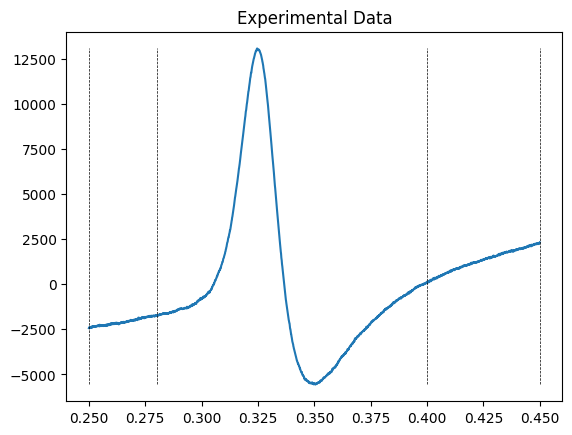

BACKGROUND FIT AIC = 15818.060742978854


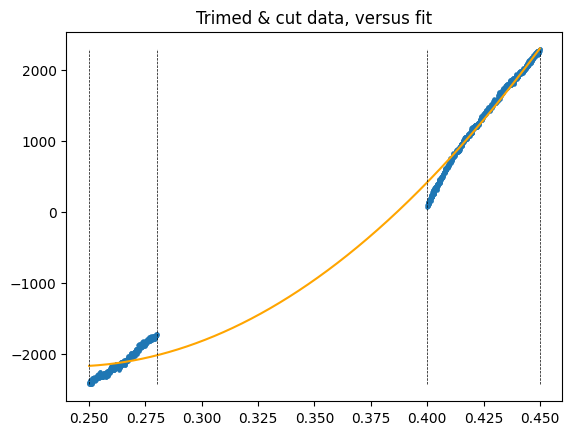

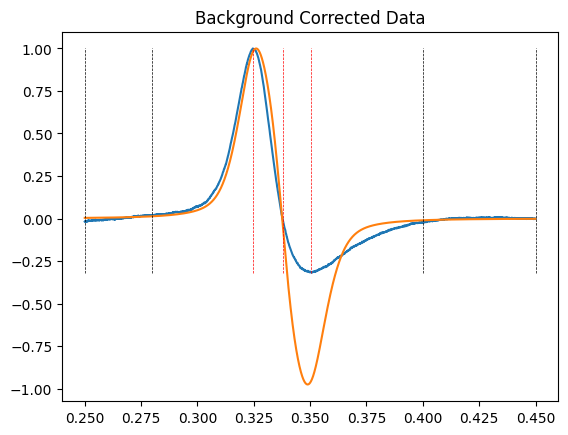

freqeuncy = 9.4378724008021 GHz
g-values guesses are: 
1.9240442334506835 1.996379338203914 2.0771746204060193


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
from lmfit import Model, minimize, Parameters
# maybe, import data.
# os.chdir(r'/Users/kumul/OneDrive - The Pennsylvania State University/EPR/Pd Thiol Toluene 32524/240325_Pd') #the r preceeding this string, produces a raw strin
filename = r'CSVs\subtracted_spectrum_PdSC4_6K_background6K_formatted_parameters'
extension = '.csv'
source = 'new'
exp_data = pull_data(filename, extension, source)
frequency = exp_data[2]
# fit to a simple quadratic background, use this to background correct, and normalize, and then use this as initial guesses? 
#print(exp_data)
# exclude a region of the spectrum...
trim = "yes"
cut = "yes"

trim_x1 = 0.25
cut_x1  = 0.28
cut_x2  = 0.4
trim_x2 = 0.45

plt.plot(exp_data[0], exp_data[1])
plt.title("Experimental Data")
plt.plot([cut_x1, cut_x1], [np.amin(exp_data[1]), np.amax(exp_data[1])], 'k', linestyle = '--', linewidth = 0.5)
plt.plot([cut_x2, cut_x2], [np.amin(exp_data[1]), np.amax(exp_data[1])], 'k', linestyle = '--', linewidth = 0.5)
plt.plot([trim_x1, trim_x1], [np.amin(exp_data[1]), np.amax(exp_data[1])], 'k', linestyle = '--', linewidth = 0.5)
plt.plot([trim_x2, trim_x2], [np.amin(exp_data[1]), np.amax(exp_data[1])], 'k', linestyle = '--', linewidth = 0.5)
plt.show()

if trim == "yes":
    trimmed_x, trimmed_y = trim_data(exp_data[0], exp_data[1], trim_x1, trim_x2)
else:
    #if we are not trimming, then we just use the originial data. 
    trimmed_x = exp_data[0]
    trimmed_y = exp_data[1]

if cut == "yes":
    trimmed_cut_x, trimmed_cut_y = cut_data(trimmed_x, trimmed_y, cut_x1, cut_x2)
else:
    # if we are not cutting, then we use the trimmed data. 
    trimmed_cut_x = trimmed_x
    trimmed_cut_y = trimmed_y

trimmed_cut_x = np.array(trimmed_cut_x)
trimmed_cut_y = np.array(trimmed_cut_y)


# then, lets fit a background to this. 
back_parameters = back_fit(trimmed_cut_x, trimmed_cut_y)


#plot what the fit looked like...
plt.title("Trimed & cut data, versus fit")
plt.scatter(trimmed_cut_x, trimmed_cut_y, s = 5)
plt.plot(np.array(trimmed_x), back_parameters[0] + back_parameters[1]*np.array(trimmed_x) + back_parameters[2]*np.array(trimmed_x)**2, color = 'orange')
plt.plot([cut_x1, cut_x1], [np.amin(trimmed_cut_y), np.amax(trimmed_cut_y)], 'k', linestyle = '--', linewidth = 0.5)
plt.plot([cut_x2, cut_x2], [np.amin(trimmed_cut_y), np.amax(trimmed_cut_y)], 'k', linestyle = '--', linewidth = 0.5)
plt.plot([trim_x1, trim_x1], [np.amin(trimmed_cut_y), np.amax(trimmed_cut_y)], 'k', linestyle = '--', linewidth = 0.5)
plt.plot([trim_x2, trim_x2], [np.amin(trimmed_cut_y), np.amax(trimmed_cut_y)], 'k', linestyle = '--', linewidth = 0.5)
plt.show()


# correct the experimental data, with this fit background. This also means that our guess for slope, intercept, quadratic term are all 0 for the fitting now. 
backcorr_x = np.array(trimmed_x)  # we only need the trimmed data, really, moving forward. 
backcorr_y = np.array(trimmed_y) - (back_parameters[0] + back_parameters[1]*np.array(trimmed_x) + back_parameters[2]*np.array(trimmed_x)**2)
backcorr_y = backcorr_y / max(backcorr_y)  # can add a multiple of -1 for 'inverted signals...'

# get guesses as to the g-factors.
B0x_guess, B0y_guess, B0z_guess = guess_B0_values(backcorr_x, backcorr_y, cut_x1, cut_x2)  # use the data BETWEEN the cut points
gx_guess = h*exp_data[2] / (beta * B0x_guess)
gy_guess = h*exp_data[2] / (beta * B0y_guess)
gz_guess = h*exp_data[2] / (beta * B0z_guess)
# FWHM OF GAUSSIAN CONTRIBUTION, IN HZ  <- use peak to peak separation? 
G_x = 0.50 * 10**9
G_y = 0.50 * 10**9
G_z = 0.50 * 10**9

# FWHM OF LORENTZIAN CONTRIBUTION, IN HZ
L_x = 0.50 * 10**9
L_y = 0.50 * 10**9
L_z = 0.50 * 10**9

#package them up...
guesses = [[gx_guess, gy_guess, gz_guess],[G_x, G_y, G_z],[L_x, L_y, L_z]]

#simulate our first guess
simulated_spectra = complete_spectra(backcorr_x, guesses, exp_data[2], thetas_phis) #returns x and y values... [sim_x, summed_y]

#########
# step 4 is to manipulate these spectra how we want (in this case we take the derivative)
#########

der_spectra = derivative(simulated_spectra) # passes both the x and the y
der_x = np.array(der_spectra[0])
der_y = np.array(der_spectra[1])
norm_der_y = der_y / max(der_y)

plt.title("Background Corrected Data")
plt.plot(backcorr_x, backcorr_y)
plt.plot(der_x, norm_der_y)
plt.plot([cut_x1, cut_x1], [np.amin(backcorr_y), np.amax(backcorr_y)], 'k', linestyle = '--', linewidth = 0.5)
plt.plot([cut_x2, cut_x2], [np.amin(backcorr_y), np.amax(backcorr_y)], 'k', linestyle = '--', linewidth = 0.5)
plt.plot([trim_x1, trim_x1], [np.amin(backcorr_y), np.amax(backcorr_y)], 'k', linestyle = '--', linewidth = 0.5)
plt.plot([trim_x2, trim_x2], [np.amin(backcorr_y), np.amax(backcorr_y)], 'k', linestyle = '--', linewidth = 0.5)

plt.plot([B0x_guess, B0x_guess], [np.amin(backcorr_y), np.amax(backcorr_y)], 'r', linestyle = '--', linewidth = 0.5)
plt.plot([B0y_guess, B0y_guess], [np.amin(backcorr_y), np.amax(backcorr_y)], 'r', linestyle = '--', linewidth = 0.5)
plt.plot([B0z_guess, B0z_guess], [np.amin(backcorr_y), np.amax(backcorr_y)], 'r', linestyle = '--', linewidth = 0.5)
plt.show()

print("freqeuncy = " + str(frequency/10**9) + " GHz")
print("g-values guesses are: ")
print(gx_guess, gy_guess, gz_guess)


to_fit = [backcorr_x, backcorr_y]  # THIS IS WHAT we will ultimately fit. 

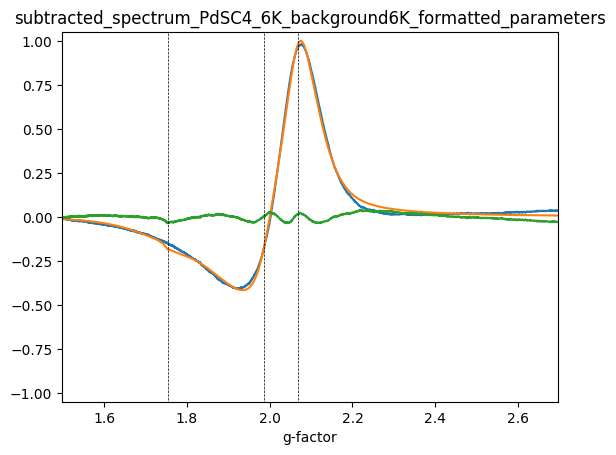

FIT RESULTS
AIC = -33970.08851569001
gx:  1.754790 (init = 1.924044) no error estimate
gy:  1.986873 (init = 1.996379) no error estimate
gz:  2.067422 (init = 2.077175) no error estimate
Gx:  11.239192 (init = 500000000.000000) no error estimate
Gy:  818404143.887093 (init = 500000000.000000) no error estimate
Gz:  428945651.517913 (init = 500000000.000000) no error estimate
Lx:  1385422289.954277 (init = 500000000.000000) no error estimate
Ly:  518900589.466052 (init = 500000000.000000) no error estimate
Lz:  363218211.970756 (init = 500000000.000000) no error estimate
scale:  28099.767832 (init = 17422.491548) no error estimate
a:  -1.202970 (init = 0.000000) no error estimate
b:  7.002809 (init = 0.000000) no error estimate
c:  -9.589331 (init = 0.000000) no error estimate
d:  0.000000 (init = 0.000000) no error estimate


In [15]:
# SINGLE FITTER
#we are not ready to move on to fitting...

####
#  NOW WE CAN FIT, ONCE WE HAVE REASONABLE GUESSES FOR DATA...
#  PV SHAPE HERE...
####
from lmfit import Model, minimize, Parameters

#######
# STEP 1:  define our model
#######
def PV_powder_ESR (x, gx, gy, gz, Gx, Gy, Gz, Lx, Ly, Lz, scale, a, b, c, d, frequency, thetas_phis):
    
    exp_data = [x, x]
    guesses = [[gx, gy, gz],[Gx, Gy, Gz],[Lx, Ly, Lz]]
    
    #get the derivative shape. 
    simulated_spectra = complete_spectra(x, guesses, frequency, thetas_phis) #returns x and y values... [sim_x, summed_y]
    der_spectra = derivative(simulated_spectra) # passes both the sim_x and the summed_y.  Returns sepctra of the length of the original x-data
    
    #get the background component
    x = np.array(x) #just make sure that we have np array
    background = a + b*x + c*x**2 + d*x**3
    return (scale * np.array(der_spectra[1]) + background) #return just the y values. 

PV_powder_model = Model(PV_powder_ESR, independent_vars=['x', 'frequency', 'thetas_phis'])  #$make sure we pass the adjustable and indpedent variables. 


########
#STEP 2: set up parameters, including indepdent ones
#######
lower_g_window = 0.28
upper_g_window = 0.37

#adjustable parameters
PV_powder_Params = PV_powder_model.make_params()
PV_powder_Params.add_many(
    ('gx',    gx_guess  ,  True, gx_guess - lower_g_window,  gz_guess + upper_g_window, None, None), #maybe the right way to set bounds is the max and min of derivative shape
    ('gy',    gy_guess  ,  True, gx_guess - lower_g_window,  gz_guess + upper_g_window, None, None), # so find the max value in y, and use that index +0.05 to find the largest g value
    ('gz',    gz_guess  ,  True, gx_guess - lower_g_window,  gz_guess + upper_g_window, None, None), # find the min value in y, and and use that index -0.5 to find the smallest g-value. Something like that. 
    
    ("Gx",    G_x ,   True, 0.0, None, None, None),
    ('Gy',    G_y ,   True, 0.0, None, None, None),
    ('Gz',    G_z ,   True, 0.0, None, None, None),
    ('Lx',    L_x ,   True, 0.0, None, None, None),
    ('Ly',    L_y ,   True, 0.0, None, None, None),
    ('Lz',    L_z ,   True, 0.0, None, None, None),
    
    ('scale', 1 / max(der_y),  True, 0.0, None, None, None), #the starting value is the ratio of the simulated to the linearly corrected experimental y 
    ('a', 0.0,                 True,  None, None, None, None),  # get an estimate here for the intercept...
    ('b', 0.0 ,                True,  None, None, None, None), # get an estimate here for the slope...
    ('c', 0.0,                 True,  None, None, None, None),
    ('d', 0.0,                 False, None, None, None, None) #right now, this is turned off.  But need to keep it here, since the model asks for it. 
    )

#non-adjustable parameters: independent parameters

#######
# step 3: fit
######

#specify we will use the Params, and then we will also explicitly pass the independent....  x = ???, frequency = ???, thetas_phis = ???

PV_powder_fit = PV_powder_model.fit(data = to_fit[1], x = to_fit[0], params = PV_powder_Params,  frequency = frequency, thetas_phis = thetas_phis)

#######
# STEP 4: plot and report
######

fit_x = np.array(to_fit[0])
fit_background = PV_powder_fit.best_values['a'] + PV_powder_fit.best_values['b'] * fit_x + PV_powder_fit.best_values['c'] * fit_x**2 + PV_powder_fit.best_values['d'] * fit_x**3

back_corr_fit = PV_powder_fit.best_fit - fit_background
back_corr_data = np.array(to_fit[1]) - fit_background

plt.title(filename)
plt.xlabel("g-factor")
plt.plot(h * frequency / (beta*fit_x), back_corr_data/ max(back_corr_fit))
plt.plot(h * frequency / (beta*fit_x), back_corr_fit / max(back_corr_fit))
plt.plot(h * frequency / (beta*fit_x), PV_powder_fit.residual/ max(back_corr_fit))
plt.ylim(-1.05,1.05)
plt.xlim(h * frequency / (beta*fit_x[-1]), h * frequency / (beta*fit_x[0]))
plt.plot([PV_powder_fit.best_values['gx'], PV_powder_fit.best_values['gx']], [-1.1,1.1], 'k', linestyle = '--', linewidth = 0.5)
plt.plot([PV_powder_fit.best_values['gy'], PV_powder_fit.best_values['gy']], [-1.1,1.1], 'k', linestyle = '--', linewidth = 0.5)
plt.plot([PV_powder_fit.best_values['gz'], PV_powder_fit.best_values['gz']], [-1.1,1.1], 'k', linestyle = '--', linewidth = 0.5)
plt.show()

print("FIT RESULTS")
print("AIC = " + str(PV_powder_fit.aic))
for param in PV_powder_fit.params.values():
    try:
        print("%s:  %f +/- %f (init = %f)" % (param.name, param.value, param.stderr, param.init_value))
    except:
        print("%s:  %f (init = %f)" % (param.name, param.value, param.init_value) + str(" no error estimate"))


#this plot is just in case you want to see the background, against the experimental data. 
#plt.plot(h * frequency / (beta*fit_x), np.array(to_fit[1][1:-1]))
#plt.plot(h * frequency / (beta*fit_x), fit_background)
#plt.xlim(h * frequency / (beta*fit_x[-1]), h * frequency / (beta*fit_x[0]))
#plt.show()

In [6]:
####
# STEP 5: Save files
#####


#here are the names of the columns. 
names = [
    'B field',           # this is the B field taken from the measurement
    'g axis',           # this is the g-space from the b field for the fitting simulation    
    'exp intensity',   # this is the experimental intensity, from the measurement. 
    '',
    'fit results',
    'fit background',
    'fit residual',
    '',
    'norm intensity',  #  this block is likely what we want to plot. Background corrected and ajusted so that the fit maximum is at 1
    'norm fit',
    'norm residual',
    '',
    'parameters',      # here is where we are going to want to store the results (and calcualtions based on them) of the fit
    'value',
    'error',
    '',
    'value fixed?',
    'notes'
]


#this is the results of the simulation.   This will be the 9 columns after the experimental data. 
simulated = [
    PV_powder_fit.best_fit, 
    fit_background, 
    PV_powder_fit.residual, 
    back_corr_data/max(back_corr_fit), 
    back_corr_fit/max(back_corr_fit), 
    PV_powder_fit.residual / max(back_corr_fit)
]

#then we set up the parameter stuff... 
# start with names that will not be in the fit results....
fit_names = ['frequency', 
             '<g>',   # this will be calculated from the gx, gy, and gz that come from the fit
             'eta x', # the three etas are calcualted from the L and G values from the fit
             'eta y', 
             'eta z', 
             'FWHM x', # the full width at half maximum for the 'convolved' band. Calculated from L and G from fit
             'FWHM y', 
             'FWHM z'
            ]  

# where we record the frequency, the average g, the eta values, and the FWHM values. 
fit_values = [frequency, 
             str((PV_powder_fit.params['gx'].value + PV_powder_fit.params['gy'].value + PV_powder_fit.params['gz'].value)/3), 
             str(eta_calc(PV_powder_fit.params['Lx'].value, PV_powder_fit.params['Gx'].value)[0]),  # here we get the eta value
             str(eta_calc(PV_powder_fit.params['Ly'].value, PV_powder_fit.params['Gy'].value)[0]),   # here we get the eta value
             str(eta_calc(PV_powder_fit.params['Lz'].value, PV_powder_fit.params['Gz'].value)[0]),  # here we get the eta value
             str(eta_calc(PV_powder_fit.params['Lx'].value, PV_powder_fit.params['Gx'].value)[1]),  # here we get the FWHM value
             str(eta_calc(PV_powder_fit.params['Ly'].value, PV_powder_fit.params['Gy'].value)[1]),  # here we get the FWHM value
             str(eta_calc(PV_powder_fit.params['Lz'].value, PV_powder_fit.params['Gz'].value)[1])]  # here we get the FWHM value

for key in PV_powder_fit.params:
    fit_names.append(str(key))
    fit_values.append(str(PV_powder_fit.params[key].value))
    
param_notes = [
    'taken from the instrument',
    'average of the gx, gy, and gz fit values, and the error is the root mean squarred of the three parameters',
    'the relative contribution of the Lorentzian profile to the Voight',
    'the relative contribution of the Lorentzian profile to the Voight',
    'the relative contribution of the Lorentzian profile to the Voight',
    'the FWHM for the Voight profile',
    'the FWHM for the Voight profile',
    'the FWHM for the Voight profile',
    'gx value',
    'gy value',
    'gz value',
    'Gaussian FWHM of the gx',
    'Gaussian FWHM of the gy',
    'Gaussian FWHM of the gz',
    'Lorentzian FWHM of the gx',
    'Lorentzian FWHM of the gy',
    'Lorentzian FWHM of the gz',
    'the entire powder pattern was multiplied by this, BUT NOT the background.  The background is calcalated separately',
    'intercept of the background',
    'slope of the intecept',
    'wieght of the x**2 term',
    'wieght of the x**3 term.  The background is calculated and then added to the scaled powder pattern.'
]

######  ERRORS #######
#need an if statement, in case there are no errors, which means that we cannot do math on them to find the rms of the error
#fit_errors = []
#if type(PV_powder_fit.params['gx'].stderr) == float :

if PV_powder_fit.params['gx'].stderr is None:
    fit_errors = ['none', 'fit could not estimate errors']

#should add something in here, where we can note if the parameter was fixed in the fitting....
else: 
    fit_errors = ['none', str((PV_powder_fit.params['gx'].stderr**2 + PV_powder_fit.params['gy'].stderr**2 + PV_powder_fit.params['gz'].stderr**2)**0.5),
              'not calc yet', 'not calc yet', 'not calc yet', 'not calc yet', 'not calc yet', 'not calc yet']
    
fit_notes = ['','','','','','','','',]  #this exists to let us know if a value was fixxed during fitting. That way, we know how to interpret an error of 0. 
for key in PV_powder_fit.params:
    fit_errors.append(str(PV_powder_fit.params[key].stderr))
    if 'fixed' in str(PV_powder_fit.params[key]) :
        fit_notes.append('yes')
    else:
        fit_notes.append('')

#collect the parameters...
extracted_params = [fit_names, fit_values, fit_errors, fit_notes, param_notes]

print(extracted_params)

# should add something that lets us insure that gz is the largest, and gx the smallest.  Need to move G and L values too..


#write the fit report, in case we want it later. 
with open(str(filename) + ' PowderFitReport_PV_linear.txt', 'w') as fh:
    fh.write(PV_powder_fit.fit_report())
    fh.close()
    
    
#save stuff for plotting. 
def save_spectra (labels, exp, sim, params):
    import csv
    with open(str(filename) + ' PowderFit_PV_linear.csv', 'w', encoding="ISO-8859-1", newline='') as myfile:
        
        #prepare and write column lables
        wr = csv.writer(myfile)
        wr.writerow(labels)
        
        g_axis = h*frequency / (beta * np.array(exp[0]))
        
        collected = [exp[0], g_axis, exp[1], [], sim[0], sim[1], sim[2], [], sim[3], sim[4], sim[5], [], params[0], params[1], params[2], [], params[3], params[4]]
        
        #collected = []
        #for i in exp :
        #    collected.append(i)

        
        #turn this into an array that can be very simply printed (not 100% sure how this works...)
        from itertools import zip_longest
        total_data = zip_longest(*collected, fillvalue = '')
        
        #write
        wr.writerows(total_data)
    myfile.close()

# call the function to write the spectral details.     
save_spectra(names, to_fit, simulated, extracted_params)



[['frequency', '<g>', 'eta x', 'eta y', 'eta z', 'FWHM x', 'FWHM y', 'FWHM z', 'gx', 'gy', 'gz', 'Gx', 'Gy', 'Gz', 'Lx', 'Ly', 'Lz', 'scale', 'a', 'b', 'c', 'd'], [9437872400.8021, '1.9363614248945036', '0.999999999905192', '0.5388978266104065', '0.6308638283705751', '1385422290.1305544', '1126381254.7787282', '653568722.8835465', '1.754789583834911', '1.9868726131990568', '2.0674220776495433', '11.239192146927616', '818404143.8870934', '428945651.5179126', '1385422289.9542773', '518900589.466052', '363218211.9707564', '28099.76783211217', '-1.2029695125751247', '7.002808923508582', '-9.5893312605769', '0.0'], ['none', 'fit could not estimate errors', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None'], ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'yes'], ['taken from the instrument', 'average of the gx, gy, and gz fit values, and the error is the root mean squarred of the three paramete

DUAL FITTER --- working from the single fit...

In [ ]:
####
#    A DAUL FITTER!  IT IS INSANITY! 
####
from lmfit import Model, minimize, Parameters

#######
# STEP 1:  define our model
#######
def dualPV_powder_ESR (x, gx, gy, gz, Gx, Gy, Gz, Lx, Ly, Lz, gx2, gy2, gz2, Gx2, Gy2, Gz2, Lx2, Ly2, Lz2, scale1, scale2, a, b, c, d, frequency, thetas_phis):
    
    exp_data = [x, x]
    guesses = [[gx, gy, gz],[Gx, Gy, Gz],[Lx, Ly, Lz]]
    guesses2 = [[gx2, gy2, gz2],[Gx2, Gy2, Gz2],[Lx2, Ly2, Lz2]]
    #isotropic
    #guesses2 = [[gx2, gx2, gz2],[Gx2, Gx2, Gz2],[Lx2, Lx2, Lz2]]
    
    #get the derivative shape. 
    simulated_spectra = complete_spectra(exp_data[0], guesses, frequency, thetas_phis) #returns x and y values... [sim_x, sim_y]
    simulated_spectra2 = complete_spectra(exp_data[0], guesses2, frequency, thetas_phis)#returns xy data as 2 dim array
    der_spectra1 = derivative(simulated_spectra) #returns xy data as 2 dim array xy
    der_spectra2 = derivative(simulated_spectra2) #returns xy data as 2 dim array xy
    #dbl_spectrum = scale1 * np.array(simulated_spectra) + scale2*np.array(simulated_spectra2)
    #der_spectra = derivative(dbl_spectrum) # passes both the x and the y
    
    #get the background component
    x = np.array(x) #just make sure that we have np array
    background = a + b*x + c*x**2 + d*x**3
    
    return (scale1 * np.array(der_spectra1[1]) + scale2 * np.array(der_spectra2[1]) + background) #return just the y values. 

dualPV_powder_model = Model(dualPV_powder_ESR, independent_vars=['x', 'frequency', 'thetas_phis'])  #$make sure we pass the adjustable and indpedent variables. 


###
# STEP 1.B: simulate the spectrum, so we can check our initial guesses before fitting. 
###
gx2_guess =  2.
gy2_guess =  2.
gz2_guess =  2.

Gx2_guess =  PV_powder_fit.params['Gx'].value *0.5
Gy2_guess =  PV_powder_fit.params['Gy'].value *0.5
Gz2_guess =  PV_powder_fit.params['Gz'].value *0.5

Lx2_guess =  PV_powder_fit.params['Lx'].value *0.5
Ly2_guess =  PV_powder_fit.params['Ly'].value *0.5
Lz2_guess =  PV_powder_fit.params['Lz'].value *0.5

scale1_guess = PV_powder_fit.params['scale'].value
scale2_guess = PV_powder_fit.params['scale'].value *1


dual_guesses_sim = dualPV_powder_ESR(
    to_fit[0],
    
    PV_powder_fit.params['gx'].value, 
    PV_powder_fit.params['gy'].value, 
    PV_powder_fit.params['gz'].value, 
    PV_powder_fit.params['Gx'].value, 
    PV_powder_fit.params['Gy'].value, 
    PV_powder_fit.params['Gz'].value, 
    PV_powder_fit.params['Lx'].value, 
    PV_powder_fit.params['Ly'].value, 
    PV_powder_fit.params['Lz'].value, 
    
    gx2_guess,
    gy2_guess,
    gz2_guess,
    Gx2_guess,
    Gy2_guess,
    Gz2_guess,
    Lx2_guess,
    Ly2_guess,
    Lz2_guess,
    
    scale1_guess ,
    scale2_guess ,
    
    PV_powder_fit.params['a'].value,
    PV_powder_fit.params['b'].value,
    PV_powder_fit.params['c'].value, 
    PV_powder_fit.params['d'].value,
    frequency,
    thetas_phis
    )

y_limits = max(np.amax(to_fit[1]), np.amax(dual_guesses_sim))

plt.title("Dual Fit Guesses")
plt.plot(h * frequency / (beta*to_fit[0]), to_fit[1])
plt.plot(h * frequency / (beta*to_fit[0]), dual_guesses_sim)

plt.plot([PV_powder_fit.params['gx'].value, PV_powder_fit.params['gx'].value], [1.05*y_limits, -1.05*y_limits], 'k', linestyle = '--', linewidth = 0.5)
plt.plot([PV_powder_fit.params['gy'].value, PV_powder_fit.params['gy'].value], [1.05*y_limits, -1.05*y_limits], 'k', linestyle = '--', linewidth = 0.5)
plt.plot([PV_powder_fit.params['gz'].value, PV_powder_fit.params['gz'].value], [1.05*y_limits, -1.05*y_limits], 'k', linestyle = '--', linewidth = 0.5)
plt.show()


In [ ]:


########
#STEP 2: set up parameters, including indepdent ones
#######

min_g = float(min(PV_powder_fit.params['gx'].value, PV_powder_fit.params['gy'].value, PV_powder_fit.params['gz'].value))  # find the smallest value from the prior fit
max_g = float(max(PV_powder_fit.params['gx'].value, PV_powder_fit.params['gy'].value, PV_powder_fit.params['gz'].value))  # find the largest value from teh prior fit

#adjustable parameters
dualPV_powder_Params = dualPV_powder_model.make_params()
dualPV_powder_Params.add_many(
    ('gx',    PV_powder_fit.params['gx'].value ,    True,  gx_guess - lower_g_window,  gz_guess + upper_g_window, None, None), #maybe the right way to set bounds is the max and min of derivative shape
    ('gy',    PV_powder_fit.params['gy'].value ,    True,  gx_guess - lower_g_window,  gz_guess + upper_g_window, None, None), # so find the max value in y, and use that index +0.05 to find the largest g value
    ('gz',    PV_powder_fit.params['gz'].value,    True,   gx_guess - lower_g_window,  gz_guess + upper_g_window, None, None),# find the min value in y, and and use that index -0.5 to find the smallest g-value. Something like that. 
    ("Gx",    PV_powder_fit.params['Gx'].value ,    True, 0.0, None, None, None),
    ('Gy',    PV_powder_fit.params['Gy'].value ,    True, 0.0, None, None, None),
    ('Gz',    PV_powder_fit.params['Gz'].value ,    True, 0.0, None, None, None),
    ('Lx',    PV_powder_fit.params['Lx'].value ,    True, 0.0, None, None, None),
    ('Ly',    PV_powder_fit.params['Ly'].value,     True, 0.0, None, None, None),
    ('Lz',    PV_powder_fit.params['Lz'].value,     True, 0.0, None, None, None),
    ('scale1', scale1_guess, True, 0.0, None, None, None), #the starting value is the ratio of the simulated to the linearly corrected experimental y 

    ('gx2',    gx2_guess ,   True, gx2_guess - lower_g_window ,  gz2_guess + upper_g_window, None, None), #maybe the right way to set bounds is the max and min of derivative shape
    ('gy2',    gy2_guess ,   True, gx2_guess - lower_g_window ,  gz2_guess + upper_g_window, None, None), # so find the max value in y, and use that index +0.05 to find the largest g value
    ('gz2',    gz2_guess ,   True, gx2_guess - lower_g_window ,  gz2_guess + upper_g_window, None, None), # find the min value in y, and and use that index -0.5 to find the smallest g-value. Something like that. 
    ("Gx2",    Gx2_guess ,   True, 0.0, None, None, None),
    ('Gy2',    Gy2_guess ,   True, 0.0, None, None, None),
    ('Gz2',    Gz2_guess ,   True, 0.0, None, None, None),
    ('Lx2',    Lx2_guess ,   True, 0.0, None, None, None),
    ('Ly2',    Ly2_guess ,   True, 0.0, None, None, None),
    ('Lz2',    Lz2_guess ,   True, 0.0, None, None, None),
    ('scale2', scale2_guess,  True, 0.0, None, None, None), #the starting value is the ratio of the simulated to the linearly corrected experimental y 
    
    ('a', PV_powder_fit.params['a'].value,  True,  None, None, None, None),  # get an estimate here for the intercept...
    ('b', PV_powder_fit.params['b'].value , True,  None, None, None, None), # get an estimate here for the slope...
    ('c', PV_powder_fit.params['c'].value,  False,  None, None, None, None),
    ('d', PV_powder_fit.params['d'].value,  False,  None, None, None, None) #right now, this is turned off.  But need to keep it here, since the model asks for it. 
    )

#non-adjustable parameters: independent parameters

#######
# step 3: fit, plot, and report
######

#specify we will use the Params, and then we will also explicitly pass the independent....  x = ???, frequency = ???, thetas_phis = ???

dual_PV_powder_fit = dualPV_powder_model.fit(data = to_fit[1], x = to_fit[0], params = dualPV_powder_Params,  frequency = frequency, thetas_phis = thetas_phis)


#######
# STEP 4: plot
######

fit_x = np.array(to_fit[0])
fit_background = dual_PV_powder_fit.best_values['a'] + dual_PV_powder_fit.best_values['b'] * fit_x + dual_PV_powder_fit.best_values['c'] * fit_x**2 + dual_PV_powder_fit.best_values['d'] * fit_x**3

back_corr_fit = dual_PV_powder_fit.best_fit - fit_background
back_corr_data = np.array(to_fit[1]) - fit_background

plt_limit = 1.05* max(
    np.amax(back_corr_data/ max(back_corr_fit)), 
    np.amax(back_corr_fit / max(back_corr_fit))
    )

plt.plot(h * frequency / (beta*fit_x), back_corr_data/ max(back_corr_fit))
plt.plot(h * frequency / (beta*fit_x), back_corr_fit / max(back_corr_fit))
plt.plot(h * frequency / (beta*fit_x), dual_PV_powder_fit.residual/ max(back_corr_fit))
plt.ylim(-1*plt_limit, plt_limit)
plt.xlim(h * frequency / (beta*fit_x[0]), h * frequency / (beta*fit_x[-1]))
plt.plot([dual_PV_powder_fit.best_values['gx'], dual_PV_powder_fit.best_values['gx']], [-1.1,1.1], 'k', linestyle = '--', linewidth = 0.5)
plt.plot([dual_PV_powder_fit.best_values['gy'], dual_PV_powder_fit.best_values['gy']], [-1.1,1.1], 'k', linestyle = '--', linewidth = 0.5)
plt.plot([dual_PV_powder_fit.best_values['gz'], dual_PV_powder_fit.best_values['gz']], [-1.1,1.1], 'k', linestyle = '--', linewidth = 0.5)
plt.plot([dual_PV_powder_fit.best_values['gx2'], dual_PV_powder_fit.best_values['gx2']], [-1.1,1.1], 'r', linestyle = '--', linewidth = 0.5)
plt.plot([dual_PV_powder_fit.best_values['gy2'], dual_PV_powder_fit.best_values['gy2']], [-1.1,1.1], 'r', linestyle = '--', linewidth = 0.5)
plt.plot([dual_PV_powder_fit.best_values['gz2'], dual_PV_powder_fit.best_values['gz2']], [-1.1,1.1], 'r', linestyle = '--', linewidth = 0.5)

plt.show()

print("FIT RESULTS")
print("AIC = " + str(dual_PV_powder_fit.aic))
for param in dual_PV_powder_fit.params.values():
    try:
        print("%s:  %f +/- %f (init = %f)" % (param.name, param.value, param.stderr, param.init_value))
    except:
        print("%s:  %f (init = %f)" % (param.name, param.value, param.init_value) + str(" no error estimate"))


In [ ]:
#write the fit report, in case we want it later. 
with open(str(filename) + ' DualPowderFitReport2.txt', 'w') as fh:
    fh.write(dual_PV_powder_fit.fit_report())
    fh.close()

    
####
# STEP 5: Save files
#####


#here are the names of the columns. 
names = [
    'B_field',           # this is the B field taken from the measurement
    'g axis',            # B_field converted to g-space. 
    'exp_intensity',     # experimental intesnity
    '',
    'rit results',   # this next block is the raw outputs from the fit.  Just so we have them
    'fit_background',
    'fit_residual',
    '',
    'norm_intensity',  #  this block is likely what we want to plot. Background corrected and ajusted so that the fit maximum is at 1
    'norm_fit',
    'norm_residual',
    '',
    'parameters',      # here is where we are going to want to store the results (and calcualtions based on them) of the fit
    'value',
    'error',
    '',
    'value fixed?',
    'notes'
]

#this is the results of the simulation.   This will be the 9 columns after the experimental data. 
simulated = [
    fit_x, 
    h*frequency / (beta * fit_x), 
    to_fit[1],
    dual_PV_powder_fit.best_fit, 
    fit_background, 
    dual_PV_powder_fit.residual, 
    back_corr_data/max(back_corr_fit), 
    back_corr_fit/max(back_corr_fit), 
    dual_PV_powder_fit.residual / max(back_corr_fit)
]

#then we set up the parameter stuff... 
# start with names that will not be in the fit results....
fit_names = ['frequency', 
             '<g>',   # this will be calculated from the gx, gy, and gz that come from the fit
             'eta x', # the three etas are calcualted from the L and G values from the fit
             'eta y', 
             'eta z', 
             'FWHM x', # the full width at half maximum for the 'convolved' band. Calculated from L and G from fit
             'FWHM y', 
             'FWHM z'
            ]  

# where we record the frequency, the average g, the eta values, and the FWHM values. 
fit_values = [frequency, 
             str(        (dual_PV_powder_fit.params['gx'].value + dual_PV_powder_fit.params['gy'].value + dual_PV_powder_fit.params['gz'].value)/3), 
             str(eta_calc(dual_PV_powder_fit.params['Lx'].value, dual_PV_powder_fit.params['Gx'].value)[0]),  # here we get the eta value
             str(eta_calc(dual_PV_powder_fit.params['Ly'].value, dual_PV_powder_fit.params['Gy'].value)[0]),   # here we get the eta value
             str(eta_calc(dual_PV_powder_fit.params['Lz'].value, dual_PV_powder_fit.params['Gz'].value)[0]),  # here we get the eta value
             str(eta_calc(dual_PV_powder_fit.params['Lx'].value, dual_PV_powder_fit.params['Gx'].value)[1]),  # here we get the FWHM value
             str(eta_calc(dual_PV_powder_fit.params['Ly'].value, dual_PV_powder_fit.params['Gy'].value)[1]),  # here we get the FWHM value
             str(eta_calc(dual_PV_powder_fit.params['Lz'].value, dual_PV_powder_fit.params['Gz'].value)[1])]  # here we get the FWHM value

for key in dual_PV_powder_fit.params:
    fit_names.append(str(key))
    fit_values.append(str(dual_PV_powder_fit.params[key].value))
    
param_notes = [
    'taken from the instrument',
    'average of the gx, gy, and gz fit values, and the error is the root mean squarred of the three parameters',
    'the relative contribution of the Lorentzian profile to the Voight',
    'the relative contribution of the Lorentzian profile to the Voight',
    'the relative contribution of the Lorentzian profile to the Voight',
    'the FWHM for the Voight profile',
    'the FWHM for the Voight profile',
    'the FWHM for the Voight profile',
    
    'gx value',
    'gy value',
    'gz value',
    'Gaussian FWHM of the gx',
    'Gaussian FWHM of the gy',
    'Gaussian FWHM of the gz',
    'Lorentzian FWHM of the gx',
    'Lorentzian FWHM of the gy',
    'Lorentzian FWHM of the gz',
    
    'gx2 value',
    'gy2 value',
    'gz2 value',
    'Gaussian FWHM of the gx2',
    'Gaussian FWHM of the gy2',
    'Gaussian FWHM of the gz2',
    'Lorentzian FWHM of the gx2',
    'Lorentzian FWHM of the gy2',
    'Lorentzian FWHM of the gz2',
    'the entire powder pattern was multiplied by this, BUT NOT the background or the relative intensity of the second component.  The background is calcalated separately',
    'This is the amount, relative to the first signal, that the second was scaled by',
    
    'intercept of the background',
    'slope of the intecept',
    'wieght of the x**2 term',
    'wieght of the x**3 term.  The background is calculated and then added to the scaled powder pattern.'
]



######  ERRORS #######
#need an if statement, in case there are no errors, which means that we cannot do math on them to find the rms of the error
#fit_errors = []
#if type(dual_PV_powder_fit.params['gx'].stderr) == float :

if dual_PV_powder_fit.params['gx'].stderr is None:
    fit_errors = ['none', 'fit could not estimate errors']

#should add something in here, where we can note if the parameter was fixed in the fitting....
else: 
    fit_errors = ['none', str((dual_PV_powder_fit.params['gx'].stderr**2 + dual_PV_powder_fit.params['gy'].stderr**2 + dual_PV_powder_fit.params['gz'].stderr**2)**0.5),
              'not calc yet', 'not calc yet', 'not calc yet', 'not calc yet', 'not calc yet', 'not calc yet']
    fit_notes = ['','','','','','','','',]  #this exists to let us know if a value was fixxed during fitting. That way, we know how to interpret an error of 0. 
    for key in dual_PV_powder_fit.params:
        fit_errors.append(str(dual_PV_powder_fit.params[key].stderr))
        if 'fixed' in str(dual_PV_powder_fit.params[key]) :
            fit_notes.append('yes')
        else:
            fit_notes.append('')

#collect the parameters...
extracted_params = [fit_names, fit_values, fit_errors, fit_notes, param_notes]

#print(extracted_params)

# should add something that lets us insure that gz is the largest, and gx the smallest.  Need to move G and L values too..


    
    
#save stuff for plotting. 
def save_spectra (labels, exp, sim, params):
    import csv
    with open(str(filename) + ' dual_PV_PowderFit_fit.csv', 'w', encoding="ISO-8859-1", newline='') as myfile:
        
        #prepare and write column lables
        wr = csv.writer(myfile)
        wr.writerow(labels)
        
        collected = [sim[0], sim[1], sim[2], [], sim[3], sim[4], sim[5], [], sim[6], sim[7], sim[8], [], params[0], params[1], params[2], [], params[3], params[4]]
        
        #collected = []
        #for i in exp :
        #    collected.append(i)

        
        #turn this into an array that can be very simply printed (not 100% sure how this works...)
        from itertools import zip_longest
        total_data = zip_longest(*collected, fillvalue = '')
        
        #write
        wr.writerows(total_data)
    myfile.close()

# call the function to write the spectral details.     
save_spectra(names, exp_data, simulated, extracted_params)



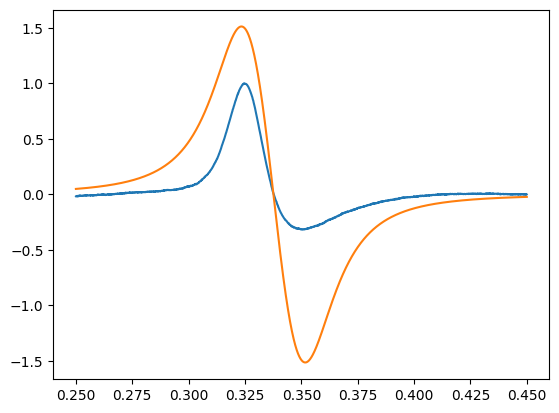

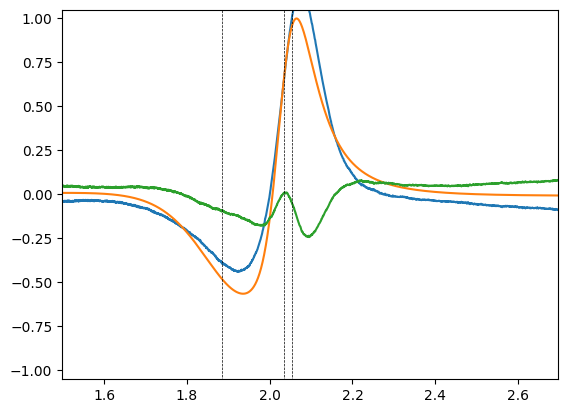

FIT RESULTS
AIC = -22295.11235433031


TypeError: must be real number, not NoneType

In [18]:
######
# CESR POWDER PATTERN, USING THE GUESSES ABOVE...
######


from lmfit import Model, minimize, Parameters

#######
# STEP 1:  define our model
#######
def Dysonian_powder_ESR (x, gx, gy, gz, Tx, Ty, Tz, Dx, Dy, Dz, scale, a, b, c, d, frequency, thetas_phis):
    
    exp_data = [x, x]
    guesses = [[gx, gy, gz],[Tx, Ty, Tz],[Dx, Dy, Dz]]
    
    #get the derivative shape. 
    simulated_spectra = complete_Dysonian_spectra(x, guesses, frequency, thetas_phis) #returns x and y values... [sim_x, summed_y]
    der_spectra = derivative(simulated_spectra) # passes both the sim_x and the summed_y.  Returns sepctra of the length of the original x-data
    
    #get the background component
    x = np.array(x) #just make sure that we have np array
    background = a + b*x + c*x**2 + d*x**3
    return (scale * np.array(der_spectra[1]) + background) #return just the y values. 

Dysonian_powder_model = Model(Dysonian_powder_ESR, independent_vars=['x', 'frequency', 'thetas_phis'])  #$make sure we pass the adjustable and indpedent variables. 

Dyson_scale = 0.003
t_guesses = [[gx_guess, gy_guess, gz_guess],[1/G_x*10**4, 1/G_y*10**4, 1/G_z*10**4],[0.0, 0.0, 0.0]]

test = complete_Dysonian_spectra(to_fit[0], t_guesses, frequency, thetas_phis)
plt.plot(to_fit[0], to_fit[1])
plt.plot(test[0], test[1]*Dyson_scale)
plt.show()


########
#STEP 2: set up parameters, including indepdent ones
#######
#adjustable parameters
Dysonian_powder_Params = Dysonian_powder_model.make_params()
Dysonian_powder_Params.add_many(
    ('gx',    gx_guess  ,  True, gx_guess - 0.2,  gz_guess + 0.1, None, None), #maybe the right way to set bounds is the max and min of derivative shape
    ('gy',    gy_guess  ,  True, gx_guess - 0.2,  gz_guess + 0.1, None, None), # so find the max value in y, and use that index +0.05 to find the largest g value
    ('gz',    gz_guess  ,  True, gx_guess - 0.2,  gz_guess + 0.1, None, None), # find the min value in y, and and use that index -0.5 to find the smallest g-value. Something like that. 
    
    ("Tx",    1/G_x*10**5 ,   True, 0.0, None, None, None),
    ('Ty',    1/G_y*10**5 ,   True, 0.0, None, None, None),
    ('Tz',    1/G_z*10**5 ,   True, 0.0, None, None, None),
    
    ('Dx',    0.0 ,   True, 0.0, 1.0, None, None),
    ('Dy',    0.0 ,   True, 0.0, 1.0, None, None),
    ('Dz',    0.0 ,   True, 0.0, 1.0, None, None),
    
    ('scale', Dyson_scale,  True, 0.0, None, None, None), #the starting value is the ratio of the simulated to the linearly corrected experimental y 
    ('a', 0.0,                 True,  None, None, None, None),  # get an estimate here for the intercept...
    ('b', 0.0 ,                True,  None, None, None, None), # get an estimate here for the slope...
    ('c', 0.0,                 False,  None, None, None, None),
    ('d', 0.0,                 False, None, None, None, None) #right now, this is turned off.  But need to keep it here, since the model asks for it. 
    )

#non-adjustable parameters: independent parameters

#######
# step 3: fit
######

#specify we will use the Params, and then we will also explicitly pass the independent....  x = ???, frequency = ???, thetas_phis = ???

Dysonian_powder_fit = Dysonian_powder_model.fit(data = to_fit[1], x = to_fit[0], params = Dysonian_powder_Params,  frequency = frequency, thetas_phis = thetas_phis)

#######
# STEP 4: plot and print report
######

fit_x = np.array(to_fit[0])
fit_background = Dysonian_powder_fit.best_values['a'] + Dysonian_powder_fit.best_values['b'] * fit_x + Dysonian_powder_fit.best_values['c'] * fit_x**2 + Dysonian_powder_fit.best_values['d'] * fit_x**3

back_corr_fit = Dysonian_powder_fit.best_fit - fit_background
back_corr_data = np.array(to_fit[1]) - fit_background

plt.plot(h * frequency / (beta*fit_x), back_corr_data/ max(back_corr_fit))
plt.plot(h * frequency / (beta*fit_x), back_corr_fit / max(back_corr_fit))
plt.plot(h * frequency / (beta*fit_x), Dysonian_powder_fit.residual/ max(back_corr_fit))
plt.ylim(-1.05,1.05)
plt.xlim(h * frequency / (beta*fit_x[-1]), h * frequency / (beta*fit_x[0]))
plt.plot([Dysonian_powder_fit.best_values['gx'], Dysonian_powder_fit.best_values['gx']], [-1.1,1.1], 'k', linestyle = '--', linewidth = 0.5)
plt.plot([Dysonian_powder_fit.best_values['gy'], Dysonian_powder_fit.best_values['gy']], [-1.1,1.1], 'k', linestyle = '--', linewidth = 0.5)
plt.plot([Dysonian_powder_fit.best_values['gz'], Dysonian_powder_fit.best_values['gz']], [-1.1,1.1], 'k', linestyle = '--', linewidth = 0.5)
plt.show()

print("FIT RESULTS")
print("AIC = " + str(Dysonian_powder_fit.aic))
for param in Dysonian_powder_fit.params.values():
    print("%s:  %f +/- %f (init = %f)" % (param.name, param.value, param.stderr, param.init_value))

    


In [17]:
def individual_Dysonian(B_field, g, g12, T, D, freq) : 
    nu_c = freq  #set the constant frequency of the spectrometer. 
    #nu0 = (g * beta * x) / h     #  makes an array for the x axis..  We use the energy gap [(g_vector[i] * beta * B_field[j])] to calculate the resonant microwave frequency for a given B.  THIS this the thing that will change as we scan the field.     
    B0 = 714.4 * freq / g *10**-13   #calculate the resonant B0...the factor of 10**-10 is because we normally have a different frequency.. should get this from first priniciple. 
    
    #then we can calculate the lineshapes, and combine then with appropriate weight...
    absorptive = 2* (28024.95266 * 10**2 * (B_field - B0) * T)
    dispersive = 1 - (28024.95266 * 10**2 * (B_field - B0) * T)**2
    
    lineshape = (D*dispersive - (1-D)*absorptive) / (1 + (28024.95266 * 10**2 * (B_field - B0) * T)**2)**2 
        
    g_intensity = g12 / g * lineshape  #this is the final spectrum for this orientation. Equation 5.27 (page 227). ******** NOTE:  ******  It is unclear right now if the vactor of "1 / g_vector[i]" should be included or not.   But its inclusion makes the results good...
        
    return(g_intensity)
    

def complete_Dysonian_spectra(x, values, freq, sphere) : 
    
    #the first thing to do, is to get the vectors needed to calculate the spectra...
    
    sim_vectors = param_vectors(values, sphere)
    
    # the next thing to do is to use the vectors to calculate the inviditual spectra...
    
    # because we are simply calcualting spectra, and because we will lose two points when we get to the derivative, we can make the x to points longer...
    # because we copied in the list, we do not need to worry about modifying the original exp spectra. 
    sim_x = list.copy(np.array(x).tolist())  # make sure the x is a list, and then copy it to sim_x
    sim_x.insert(0, x[0] - (x[1]-x[0]))    # add a value at the front
    sim_x.append(x[-1] + (x[-1] - x[-2]))  # add a value at the end
    sim_x = np.array(sim_x)     # make sure our x-vector is a np array...
    y_summed = sim_x*0   # make sure we have a vector that is the same length as the x, but with zeros to start...
    
    #separate out the vectors from the g_stuff, so we can iterate over them
    g   = sim_vectors[0]
    g12 = sim_vectors[1]
    T   = sim_vectors[2]
    D   = sim_vectors[3]
    
    #step 2, we start a FOR loop, that will interate over all of the sampled orientations, calling for the individual spectra adn then adding them...
    # this will generate the final integrated spectrum
    for a,b,c,d in zip(g, g12, T, D): 
        y_summed = y_summed + individual_Dysonian(sim_x, a,b,c,d, freq)    
    
    #then we return the final values...
    
    return(sim_x, y_summed)  # return the simulated x and the associated y. 

In [21]:

print(Dysonian_powder_fit.fit_report())

[[Model]]
    Model(Dysonian_powder_ESR)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26000
    # data points      = 4094
    # variables        = 12
    chi-square         = 17.5598278
    reduced chi-square = 0.00430177
    Akaike info crit   = -22295.1124
    Bayesian info crit = -22219.3050
    R-squared          = 0.93953522
##  Warning: uncertainties could not be estimated:
    Tz:     at boundary
[[Variables]]
    gx:     1.88482698 (init = 1.924044)
    gy:     2.03464129 (init = 1.996379)
    gz:     2.05323003 (init = 2.077175)
    Tx:     8.1208e-06 (init = 0.0002)
    Ty:     2.7260e-05 (init = 0.0002)
    Tz:     4.6287e-09 (init = 0.0002)
    Dx:     0.99993134 (init = 0)
    Dy:     0.99997686 (init = 0)
    Dz:     0.99994819 (init = 0)
    scale:  1.7973e-05 (init = 0.003)
    a:      0.08155342 (init = 0)
    b:     -0.11280638 (init = 0)
    c:      0 (fixed)
    d:      0 (fixed)


In [22]:
for param in Dysonian_powder_fit.params.values():
    print("%s:  %f init = %f)" % (param.name, param.value, param.init_value))

TypeError: not enough arguments for format string

In [23]:
for param in Dysonian_powder_fit.params.values():
    print("%s:  %f (init = %f)" % (param.name, param.value, param.init_value))

gx:  1.884827 (init = 1.924044)
gy:  2.034641 (init = 1.996379)
gz:  2.053230 (init = 2.077175)
Tx:  0.000008 (init = 0.000200)
Ty:  0.000027 (init = 0.000200)
Tz:  0.000000 (init = 0.000200)
Dx:  0.999931 (init = 0.000000)
Dy:  0.999977 (init = 0.000000)
Dz:  0.999948 (init = 0.000000)
scale:  0.000018 (init = 0.003000)
a:  0.081553 (init = 0.000000)
b:  -0.112806 (init = 0.000000)
c:  0.000000 (init = 0.000000)
d:  0.000000 (init = 0.000000)
